# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
回測K棒數量,1000
總報酬率,115347.50
日報酬率,18.4597
最大回撤,-41.66
交易次數,593
勝率,17.54
平均每筆報酬率,1.41
平均獲利時報酬,16.26
平均虧損時報酬,-1.75
盈虧比,9.31


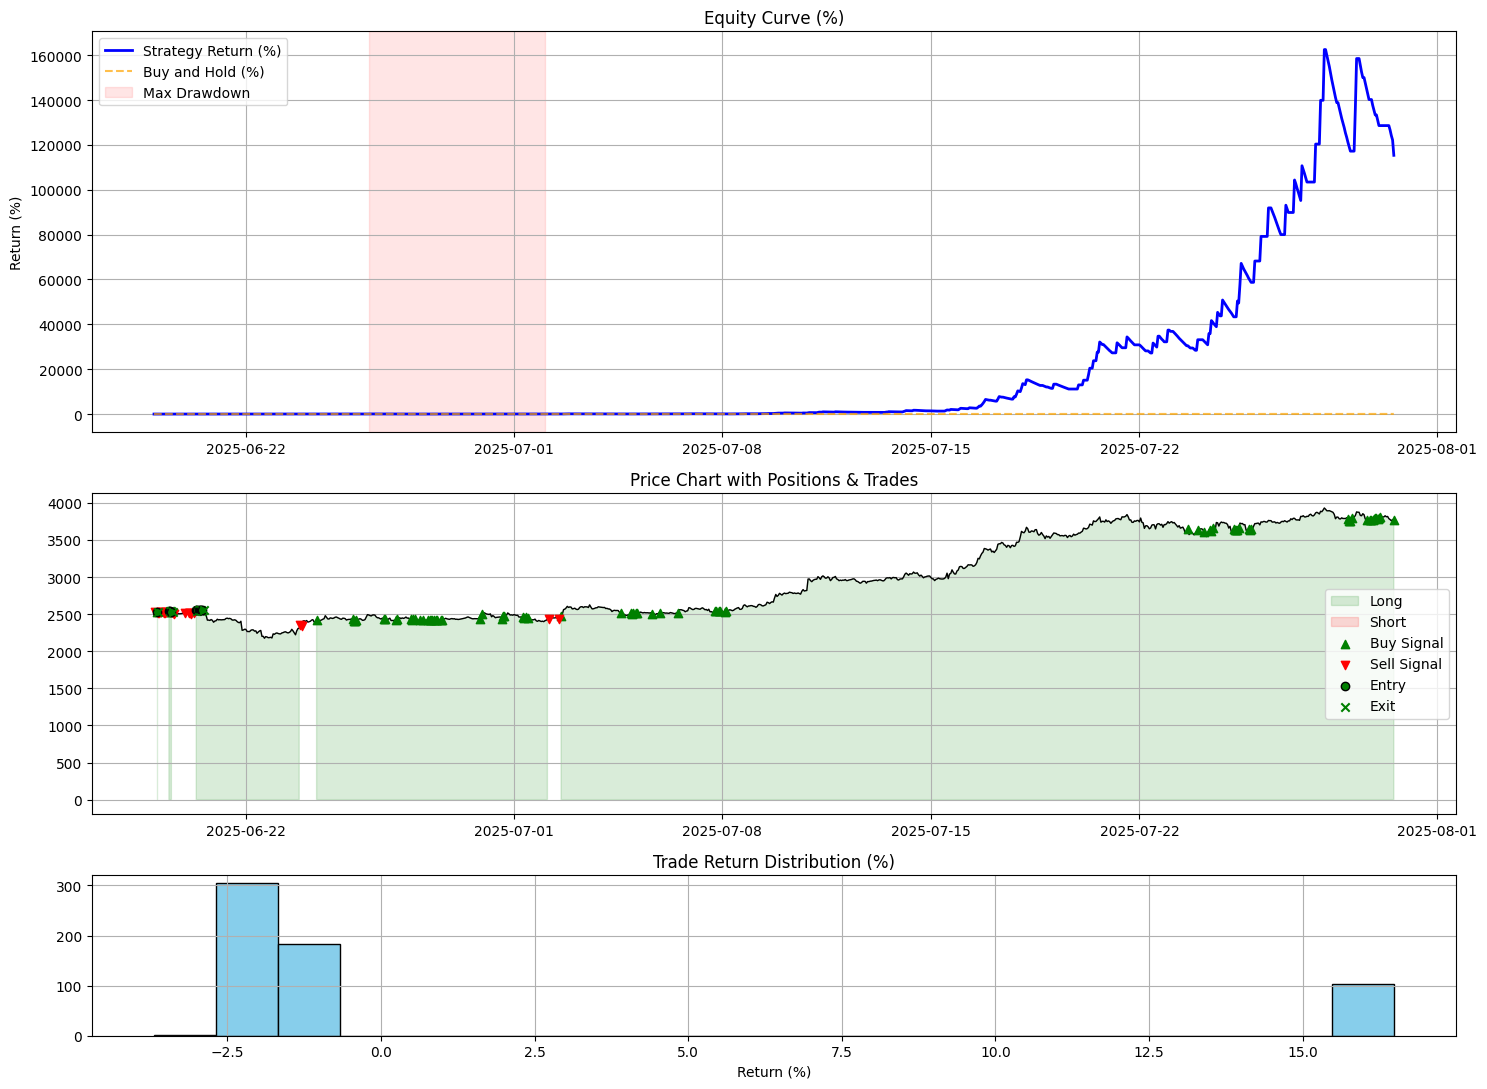

In [7]:
from Technicalindicatorstrategy import vegas
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import pandas as pd
from datetime import datetime,timedelta
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)  # ✅ 固定隨機性（可重現性）
import random
random.seed(42)

df_signals = vegas.get_signals('ETHUSDT','1h',datetime.now()-timedelta(days=1),1000)

result = backtest_signals(
    df_signals.copy(),
    initial_capital = 33, # 1000台幣
    fee_rate = 0.0005, # 合約手續費
    leverage = 10, # 槓桿
    allow_short = False, # 是否做空
    stop_loss = 0.001,       # 停損閾值，例如0.05代表5%
    take_profit = 0.017,     # 停利閾值
    capital_ratio = 1, # 每次使用的資金佔比
    max_hold_bars = 1000)  # 最大持有K棒數
display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from binance.client import Client
import pandas as pd
import time
import requests
import os
from Technicalindicatorstrategy import vegas
from datetime import datetime
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()

# Binance API Key (可為空)
client = Client(api_key='', api_secret='')

# 取得成交量最高的 USDT 交易對，過濾掉 BULL/BEAR 等槓桿代幣。
def get_top_symbols(limit=100, quote_asset='USDT'):
    tickers = client.get_ticker()
    usdt_pairs = [
        t for t in tickers if t['symbol'].endswith(quote_asset)
        and not t['symbol'].endswith('BULLUSDT')
        and not t['symbol'].endswith('BEARUSDT')
    ]
    sorted_pairs = sorted(usdt_pairs, key=lambda x: float(x['quoteVolume']), reverse=True)
    return [t['symbol'] for t in sorted_pairs[:limit]]

symbols = get_top_symbols(limit=100)
metrics = {}

for symbol in tqdm(symbols):
    try:
        df_signals = vegas.get_signals(symbol, '1h', datetime.now() - timedelta(days=1), 1000)

        result = backtest_signals(
            df_signals.copy(),
            initial_capital=33,
            fee_rate=0.0005,
            leverage=10,
            allow_short=False,
            stop_loss=0.001,
            take_profit=0.017,
            capital_ratio=1,
            max_hold_bars=1000
        )

        roi = result['metric']['總報酬率']
        metrics[symbol] = roi

    except Exception as e:
        print(f"Error processing {symbol}: {e}")
        metrics[symbol] = None  # 可以標記為None來區分異常值

# 轉換成 DataFrame 10x10
symbols_list = list(metrics.keys())
roi_list = list(metrics.values())

import numpy as np

df = pd.DataFrame({
    'Symbol': symbols_list,
    'ROI': roi_list
})

# 過濾掉 ROI 是 None 的幣種
clean_df = df.dropna(subset=['ROI']).reset_index(drop=True)

# 確保可以 reshape 成 10x10，先取前 100 筆有效資料
clean_df = clean_df.head(100)

# 建立 ROI 與標籤的矩陣
roi_matrix = clean_df['ROI'].values.reshape(10, 10).astype(float)


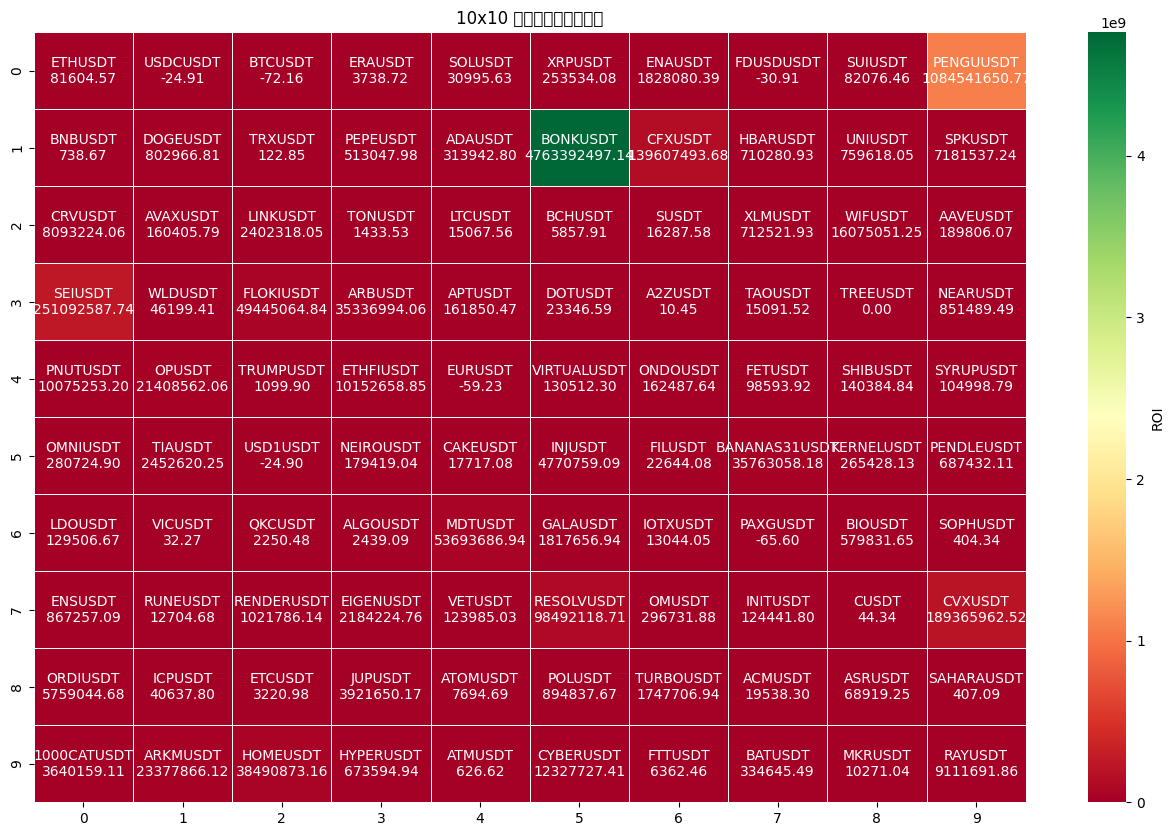

In [4]:
symbol_matrix = clean_df.apply(lambda row: f"{row['Symbol']}\n{row['ROI']}", axis=1).values.reshape(10, 10)

# 畫熱力圖
plt.figure(figsize=(16, 10))
sns.heatmap(roi_matrix, annot=symbol_matrix, fmt='', cmap='RdYlGn', linewidths=0.5, cbar_kws={'label': 'ROI'})
plt.title('10x10 幣種總報酬率熱力圖')
plt.show()